# Basic Example of Usage for the DMD variants on the CTF4Scienxce datasets

This notebook demonstrates how to use the DMD variants on the CTF4Science datasets. We will cover the following steps:
- Importing datasets
- Visualizing the data
- Applying Optimised DMD from the `pydmd` library

In [1]:
from ctf4science.data_module import load_dataset, get_training_timesteps
import matplotlib.pyplot as plt
import numpy as np
from pydmd import BOPDMD, HODMD

## ODE Lorenz

Let us load and visualize the Lorenz dataset first.

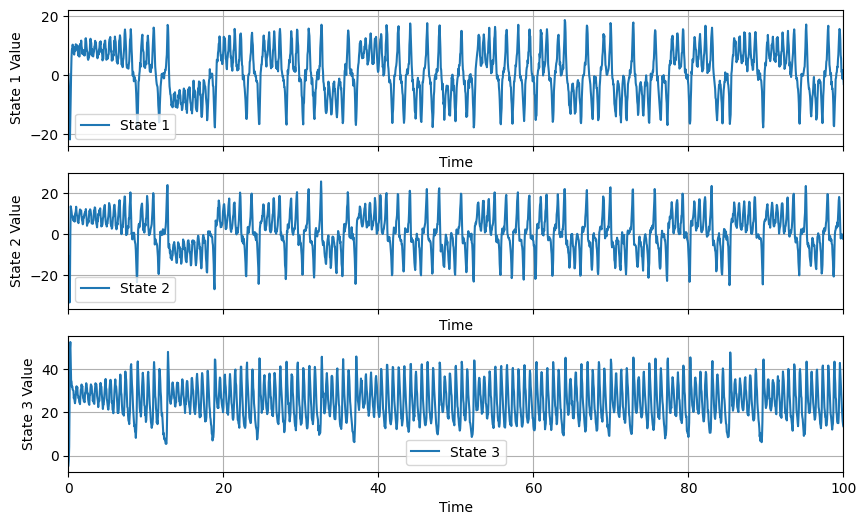

In [2]:
lorenz_data = np.array(load_dataset('ODE_Lorenz', pair_id = 2, transpose=True)[0])[0]
lorenz_time = get_training_timesteps('ODE_Lorenz', 2)[0]

fig, axs = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

for ii in range(len(axs)):
    axs[ii].plot(lorenz_time, lorenz_data[ii, :], label=f'State {ii+1}')
    axs[ii].set_xlabel('Time')
    axs[ii].set_ylabel(f'State {ii+1} Value')
    axs[ii].legend()
    axs[ii].grid()

    axs[ii].set_xlim(0,100)

Separate data into train and test sets.

In [3]:
train_idx = np.arange(0, int(0.85 * lorenz_data.shape[1]))
test_idx = np.arange(int(0.85 * lorenz_data.shape[1]), lorenz_data.shape[1])

lorenz_train = lorenz_data[:, train_idx]
lorenz_test = lorenz_data[:, test_idx]
lorenz_time_train = lorenz_time[train_idx]
lorenz_time_test = lorenz_time[test_idx]

Let us train the DMD model

In [4]:
# Fit the HODMD model
lorenz_hodmd = HODMD(svd_rank=-1, d=50)
lorenz_hodmd.fit(lorenz_train)
lorenz_hodmd.original_time['t0'] = lorenz_time_train[0]
lorenz_hodmd.original_time['dt'] = lorenz_time_train[1] - lorenz_time_train[0]
lorenz_hodmd.original_time['tend'] = lorenz_time_train[-1]

# Fit BOPDMD model
lorenz_bopdmd = BOPDMD(svd_rank = -1, 
                    eig_constraints={'stable'}
                    )
lorenz_bopdmd.fit(lorenz_train, lorenz_time_train)

/Users/sriva/miniconda3/envs/ctf/lib/python3.10/site-packages/pydmd/bopdmd.py:973: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


Let us reconstruct and visualize the results

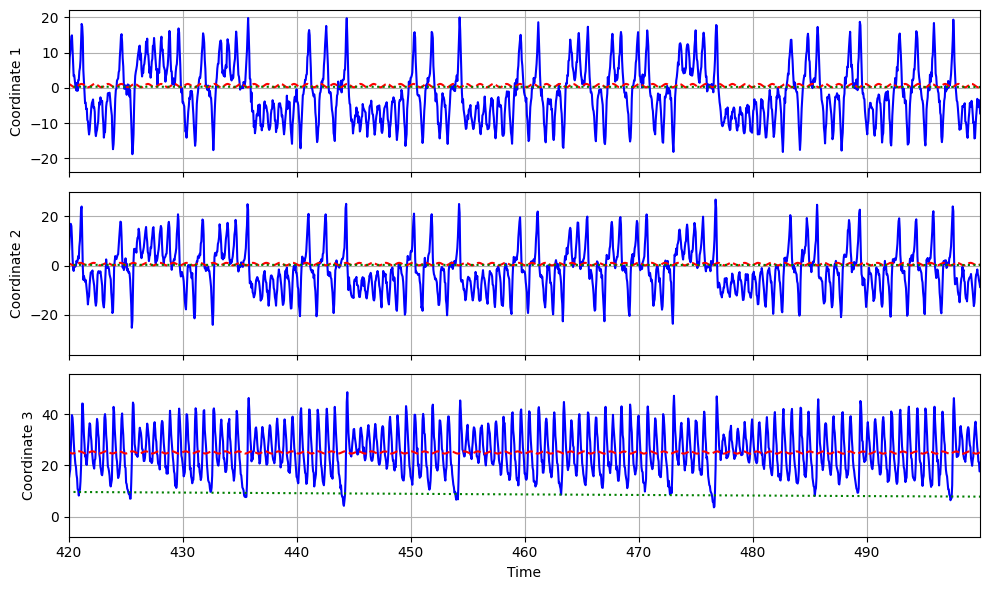

In [21]:
lorenz_hodmd.dmd_time['t0'] = lorenz_time[0]
lorenz_hodmd.dmd_time['dt'] = lorenz_time[1] - lorenz_time[0]
lorenz_hodmd.dmd_time['tend'] = lorenz_time[-1]
lorenz_recon_hodmd = lorenz_hodmd.reconstructed_data.real

lorenz_recon_bopdmd = lorenz_bopdmd.forecast(lorenz_time).real

fig, axs = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

for ii in range(len(axs)):
    axs[ii].plot(lorenz_time, lorenz_data[ii, :], label=f'Original State {ii+1}', color='blue')
    axs[ii].plot(lorenz_time, lorenz_recon_bopdmd[ii, :], '--', label=f'Reconstructed State {ii+1}', 
    color='red')
    axs[ii].plot(lorenz_time, lorenz_recon_hodmd[ii, :], ':', label=f'HODMD Reconstructed State {ii+1}', 
    color='green')
    axs[ii].set_ylabel(f'Coordinate {ii+1}')
    axs[ii].grid()

    axs[ii].set_xlim(int(lorenz_time_test[0])-5, lorenz_time[-1])
axs[-1].set_xlabel('Time')

plt.tight_layout()

## Kuramoto-Sivashinsky
Let us load and visualize the Kuramoto-Sivashinsky dataset first.

Text(0, 0.5, 'Spatial Coordinate')

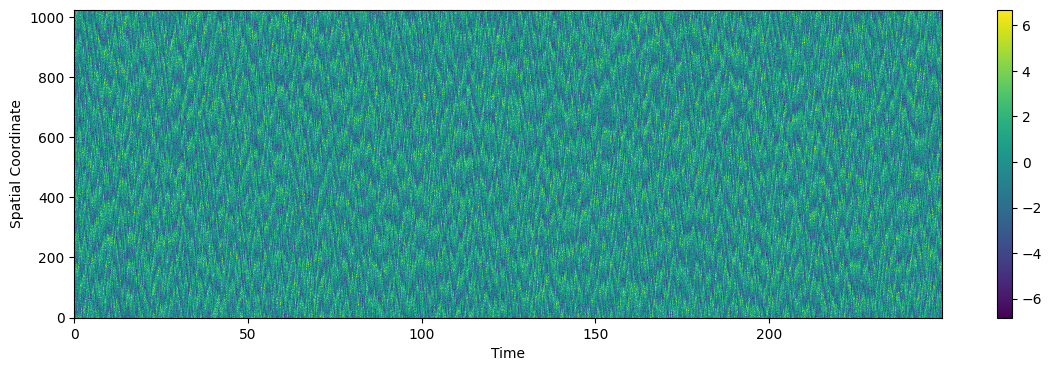

In [6]:
ks_dataset = np.array(load_dataset('PDE_KS', pair_id = 2, transpose=True)[0])[0]
ks_time = get_training_timesteps('PDE_KS', 2)[0]

x = np.arange(ks_dataset.shape[0])

xgrid, tgrid = np.meshgrid(x, ks_time)

fig, ax = plt.subplots(figsize=(14, 4))

c = ax.pcolormesh(tgrid, xgrid, ks_dataset.T, shading='auto', cmap='viridis')
fig.colorbar(c, ax=ax)
ax.set_xlabel('Time')
ax.set_ylabel('Spatial Coordinate')

Separate data into train and test sets.

In [7]:
train_idx = np.arange(0, int(0.85 * ks_dataset.shape[1]))
test_idx = np.arange(int(0.85 * ks_dataset.shape[1]), ks_dataset.shape[1])

ks_train = ks_dataset[:, train_idx]
ks_test = ks_dataset[:, test_idx]
ks_time_train = ks_time[train_idx]
ks_time_test = ks_time[test_idx]

Let us perform a preliminary SVD

/Users/sriva/miniconda3/envs/ctf/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/sriva/miniconda3/envs/ctf/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/sriva/miniconda3/envs/ctf/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/sriva/miniconda3/envs/ctf/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/sriva/miniconda3/envs/ctf/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/sriva/miniconda3/envs/ctf/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: invalid value encountered in matmul
  Q, 

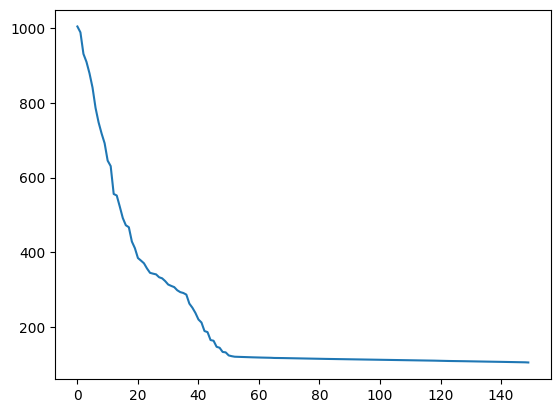

In [9]:
from sklearn.decomposition import randomized_svd

sing_vals = randomized_svd(ks_train, n_components=150, n_iter='auto', random_state=42)[1]

plt.plot(sing_vals)

Let us train the DMD model

In [10]:
ks_hodmd = HODMD(svd_rank=150, d=20)
ks_hodmd.fit(ks_train)
ks_hodmd.original_time['t0'] = ks_time_train[0]
ks_hodmd.original_time['dt'] = ks_time_train[1] - ks_time_train[0]
ks_hodmd.original_time['tend'] = ks_time_train[-1]

ks_bopdmd = BOPDMD(    svd_rank = 50,
                    eig_constraints={'stable'}
                    )

ks_bopdmd.fit(ks_train, ks_time_train)

/Users/sriva/miniconda3/envs/ctf/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/sriva/miniconda3/envs/ctf/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/sriva/miniconda3/envs/ctf/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/Users/sriva/miniconda3/envs/ctf/lib/python3.10/site-packages/pydmd/bopdmd.py:973: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


Let us reconstruct and visualize the results

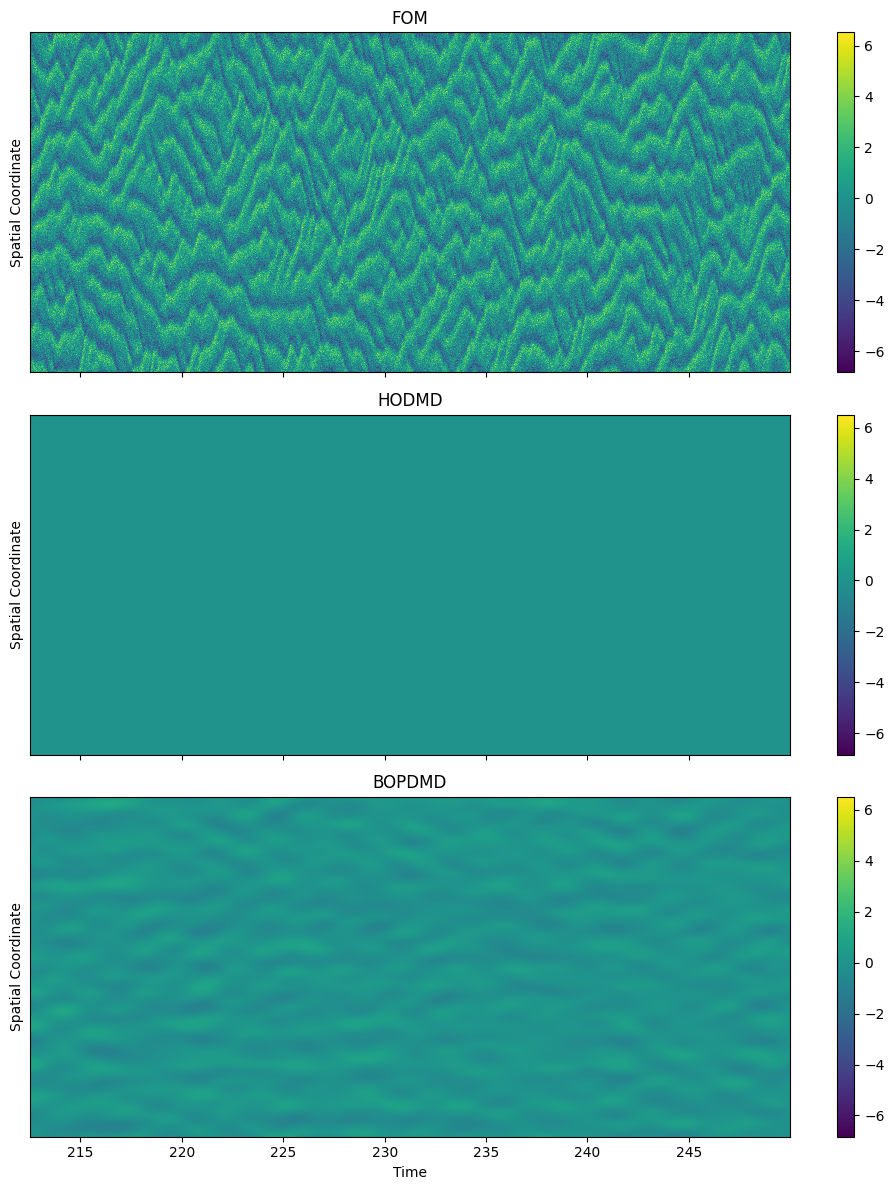

In [22]:
ks_hodmd.dmd_time['t0'] = ks_time_test[0]
ks_hodmd.dmd_time['dt'] = ks_time_test[1] - ks_time_test[0]
ks_hodmd.dmd_time['tend'] = ks_time_test[-1]
ks_recon_hodmd = ks_hodmd.reconstructed_data.real[:, :ks_time_test.shape[0]]

ks_recon_bopdmd = ks_bopdmd.forecast(ks_time_test).real


xgrid_test, tgrid_test = np.meshgrid(x, ks_time_test)

fig, axs = plt.subplots(3, 1, figsize=(10, 4 * 3), sharex=True, sharey=True)

c = axs[0].pcolormesh(tgrid_test, xgrid_test, ks_test.T, shading='auto', cmap='viridis',
                      vmin = ks_test.min(), vmax = ks_test.max())
fig.colorbar(c, ax=axs[0])
axs[0].set_title('FOM')

axs[1].pcolormesh(tgrid_test, xgrid_test, ks_recon_hodmd.T, shading='auto', cmap='viridis',
                        vmin = ks_test.min(), vmax = ks_test.max())
fig.colorbar(c, ax=axs[1])
axs[1].set_title('HODMD')

axs[2].pcolormesh(tgrid_test, xgrid_test, ks_recon_bopdmd.T, shading='auto', cmap='viridis',
                        vmin = ks_test.min(), vmax = ks_test.max())
fig.colorbar(c, ax=axs[2])
axs[2].set_title('BOPDMD')

for ax in axs:
    # ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel('Spatial Coordinate')

axs[-1].set_xlabel('Time')

plt.tight_layout()

## Seismo
Let us load and visualize the Seismo dataset first.

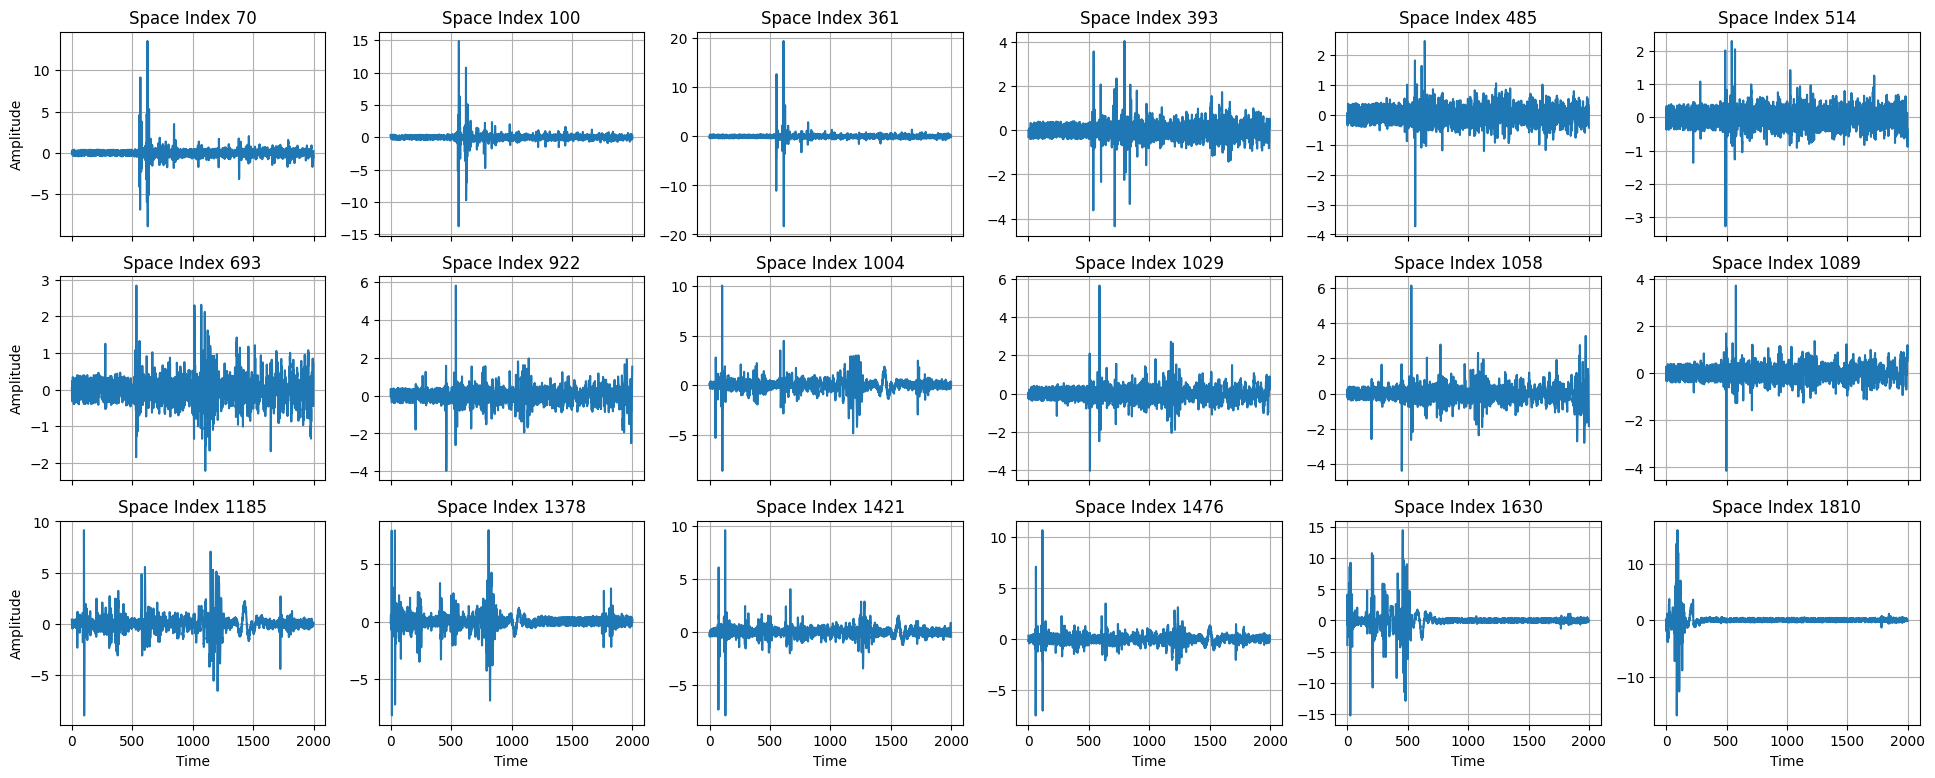

In [23]:
seismo_dataset = np.array(load_dataset('seismo', pair_id = 2, transpose=True)[0])[0]
seismo_time = get_training_timesteps('seismo', 2)[0]

np.random.seed(42)
space_idx_to_plot = np.sort(np.random.choice(seismo_dataset.shape[0], size=18, replace=False))
nrows = 3
ncols = 6

fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows), sharex=True)
for i, ax in enumerate(axs.flat):
    space_idx = space_idx_to_plot[i]
    ax.plot(seismo_time, seismo_dataset[space_idx, :], label=f'Space Index {space_idx}')
    ax.set_title(f'Space Index {space_idx}')
    ax.grid()

    if i // ncols == nrows - 1:
        ax.set_xlabel('Time')
    if i % ncols == 0:
        ax.set_ylabel('Amplitude')

Separate data into train and test sets.

In [24]:
train_idx = np.arange(0, int(0.85 * seismo_dataset.shape[1]))
test_idx = np.arange(int(0.85 * seismo_dataset.shape[1]), seismo_dataset.shape[1])

seismo_train = seismo_dataset[:, train_idx]
seismo_test = seismo_dataset[:, test_idx]
seismo_time_train = seismo_time[train_idx]
seismo_time_test = seismo_time[test_idx]

Let us perform a preliminary SVD

/Users/sriva/miniconda3/envs/ctf/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/sriva/miniconda3/envs/ctf/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/sriva/miniconda3/envs/ctf/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/sriva/miniconda3/envs/ctf/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/sriva/miniconda3/envs/ctf/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/sriva/miniconda3/envs/ctf/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: invalid value encountered in matmul
  Q, 

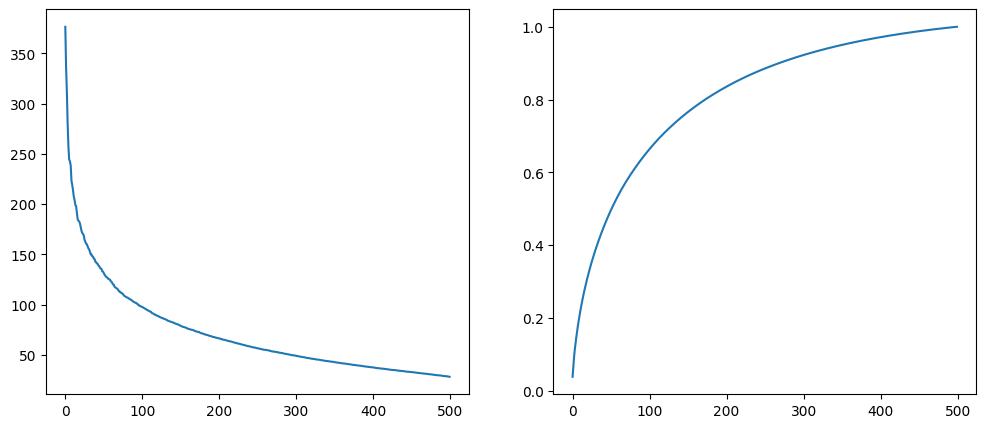

In [25]:
from sklearn.utils.extmath import randomized_svd

sing_vals = randomized_svd(seismo_train, n_components=500, n_iter='auto', random_state=42)[1]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(sing_vals)
axs[1].plot(np.cumsum(sing_vals**2) / np.sum(sing_vals**2))

Let us train the DMD model

In [26]:
seismo_hodmd = HODMD(svd_rank=200, d=30)
seismo_hodmd.fit(seismo_train)
seismo_hodmd.original_time['t0'] = seismo_time_train[0]
seismo_hodmd.original_time['dt'] = seismo_time_train[1] - seismo_time_train[0]
seismo_hodmd.original_time['tend'] = seismo_time_train[-1]

seismo_dmd = BOPDMD(    svd_rank = 150,
                    eig_constraints={'stable'}
                    )
seismo_dmd.fit(seismo_train, seismo_time_train)

/Users/sriva/miniconda3/envs/ctf/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/sriva/miniconda3/envs/ctf/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/sriva/miniconda3/envs/ctf/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/Users/sriva/miniconda3/envs/ctf/lib/python3.10/site-packages/pydmd/bopdmd.py:973: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


Let us reconstruct and visualize the results

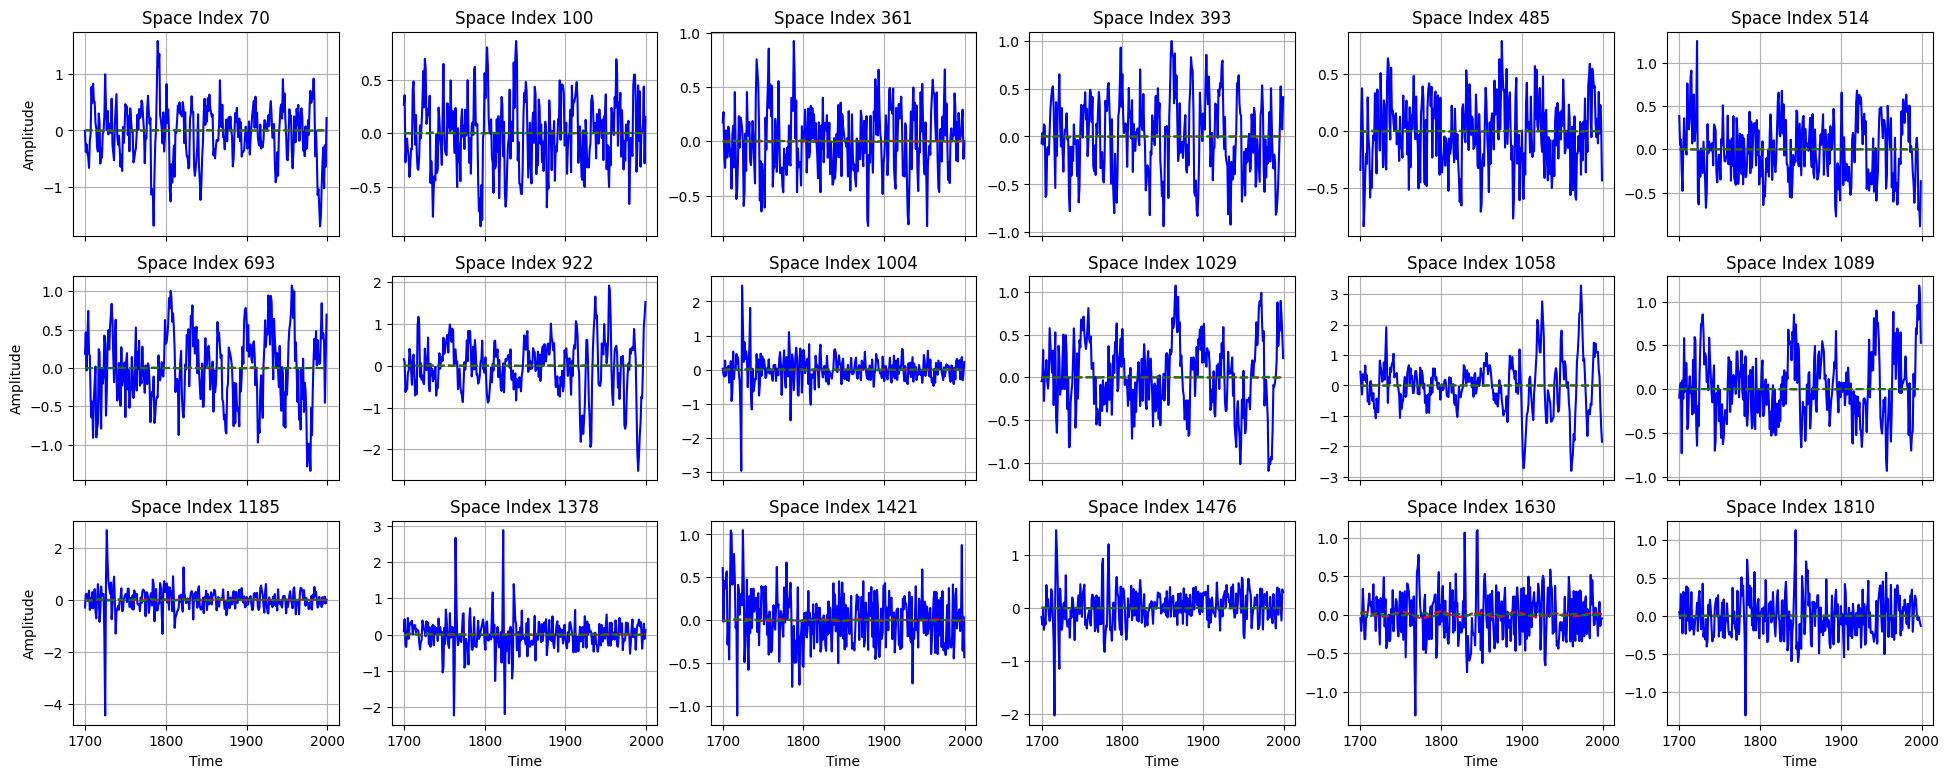

In [27]:
seismo_hodmd.dmd_time['t0'] = seismo_time_test[0]
seismo_hodmd.dmd_time['dt'] = seismo_time_test[1] - seismo_time_test[0]
seismo_hodmd.dmd_time['tend'] = seismo_time_test[-1]
seismo_recon_hodmd = seismo_hodmd.reconstructed_data.real[:, :seismo_time_test.shape[0]]

seismo_recon_bopdmd = seismo_dmd.forecast(seismo_time_test).real

fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows), sharex=True)
for i, ax in enumerate(axs.flat):
    space_idx = space_idx_to_plot[i]
    ax.plot(seismo_time_test, seismo_test[space_idx, :], label=f'FOM Space Index {space_idx}', color='blue')
    ax.plot(seismo_time_test, seismo_recon_bopdmd[space_idx, :], '--', label=f'DMD Space Index {space_idx}', color='red')
    ax.plot(seismo_time_test, seismo_recon_hodmd[space_idx, :], '--', label=f'HODMD Space Index {space_idx}', color='green')
    ax.set_title(f'Space Index {space_idx}')
    ax.grid()

    if i // ncols == nrows - 1:
        ax.set_xlabel('Time')
    if i % ncols == 0:
        ax.set_ylabel('Amplitude')

## Ocean DAS
Let us load and visualize the Ocean DAS dataset first.

Text(0, 0.5, 'Spatial Coordinate')

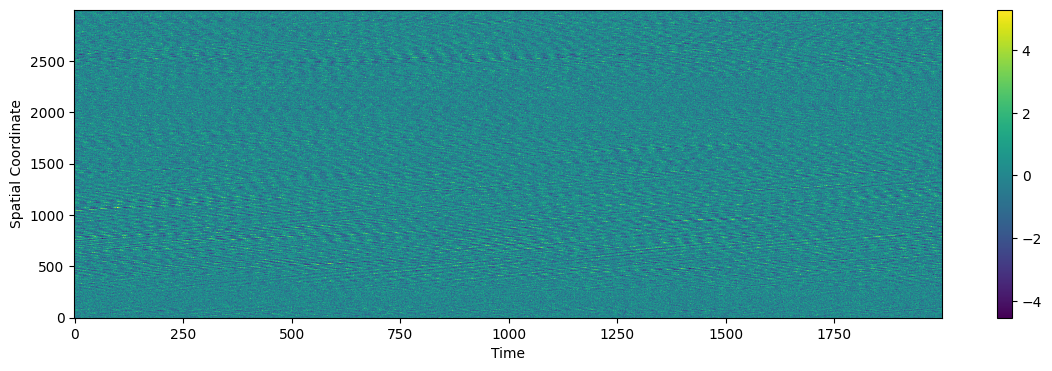

In [2]:
ocean_dataset = load_dataset('ocean_das', pair_id = 2, transpose=True)[0][0]
ocean_time = get_training_timesteps('ocean_das', 2)[0]

x = np.arange(ocean_dataset.shape[0])
xgrid, tgrid = np.meshgrid(x, ocean_time)

fig, ax = plt.subplots(figsize=(14, 4))

c = ax.pcolormesh(tgrid, xgrid, ocean_dataset.T, shading='auto', cmap='viridis')
fig.colorbar(c, ax=ax)
ax.set_xlabel('Time')
ax.set_ylabel('Spatial Coordinate')

Separate data into train and test sets.

In [3]:
train_idx = np.arange(0, int(0.85 * ocean_dataset.shape[1]))
test_idx = np.arange(int(0.85 * ocean_dataset.shape[1]), ocean_dataset.shape[1])

ocean_train = ocean_dataset[:, train_idx]
ocean_test = ocean_dataset[:, test_idx]
ocean_time_train = ocean_time[train_idx]
ocean_time_test = ocean_time[test_idx]

Let us perform a preliminary SVD

/Users/sriva/miniconda3/envs/ctf/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/sriva/miniconda3/envs/ctf/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/sriva/miniconda3/envs/ctf/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/sriva/miniconda3/envs/ctf/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/sriva/miniconda3/envs/ctf/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/sriva/miniconda3/envs/ctf/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: invalid value encountered in matmul
  Q, 

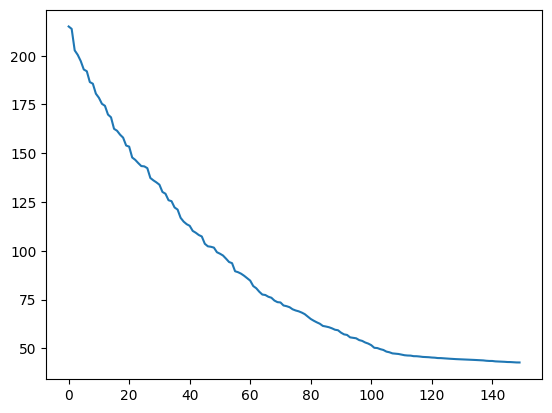

In [4]:
from sklearn.utils.extmath import randomized_svd

sing_vals = randomized_svd(ocean_train, n_components=150, n_iter='auto', random_state=42)[1]

plt.plot(sing_vals)

Let us train the DMD model

In [5]:
ocean_hodmd = HODMD(svd_rank=100, d=20)
ocean_hodmd.fit(ocean_train)
ocean_hodmd.original_time['t0'] = ocean_time_train[0]
ocean_hodmd.original_time['dt'] = ocean_time_train[1] - ocean_time_train[0]
ocean_hodmd.original_time['tend'] = ocean_time_train[-1]

ocean_dmd = BOPDMD(    svd_rank = 100,
                     eig_constraints={'stable'}
                     )
ocean_dmd.fit(ocean_train, ocean_time_train)

/Users/sriva/miniconda3/envs/ctf/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/sriva/miniconda3/envs/ctf/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/sriva/miniconda3/envs/ctf/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/Users/sriva/miniconda3/envs/ctf/lib/python3.10/site-packages/pydmd/bopdmd.py:973: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


Let us reconstruct and visualize the results

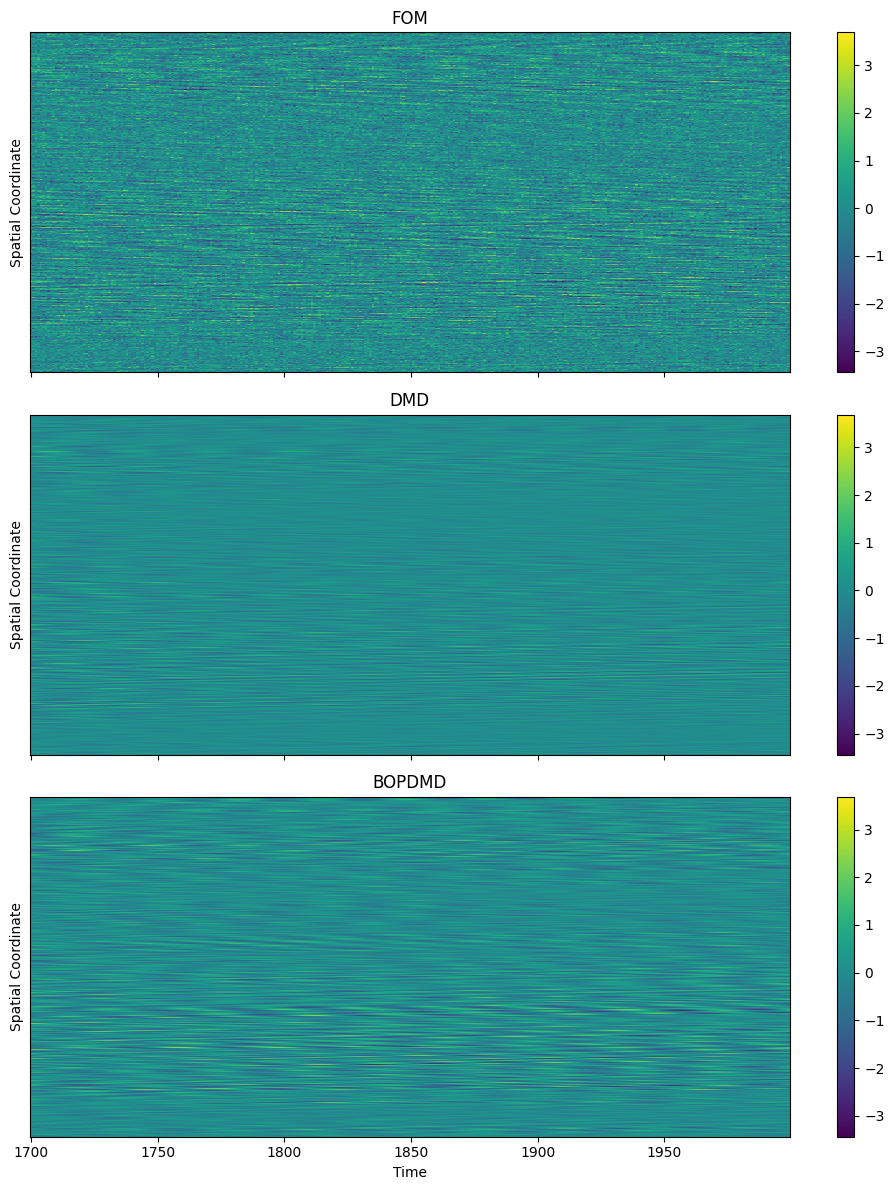

In [6]:
ocean_hodmd.dmd_time['t0'] = ocean_time_test[0]
ocean_hodmd.dmd_time['dt'] = ocean_time_test[1] - ocean_time_test[0]
ocean_hodmd.dmd_time['tend'] = ocean_time_test[-1]
ocean_recon_hodmd = ocean_hodmd.reconstructed_data.real[:, :ocean_time_test.shape[0]]

ocean_recon_bopdmd = ocean_dmd.forecast(ocean_time_test).real

xgrid_test, tgrid_test = np.meshgrid(x, ocean_time_test)

fig, axs = plt.subplots(3, 1, figsize=(10, 4 * 3), sharex=True, sharey=True)

c = axs[0].pcolormesh(tgrid_test, xgrid_test, ocean_test.T, shading='auto', cmap='viridis',
                      vmin = ocean_test.min(), vmax = ocean_test.max())
fig.colorbar(c, ax=axs[0])
axs[0].set_title('FOM')

axs[1].pcolormesh(tgrid_test, xgrid_test, ocean_recon_hodmd.T, shading='auto', cmap='viridis',
                        vmin = ocean_test.min(), vmax = ocean_test.max())
fig.colorbar(c, ax=axs[1])
axs[1].set_title('DMD')

axs[2].pcolormesh(tgrid_test, xgrid_test, ocean_recon_bopdmd.T, shading='auto', cmap='viridis',
                        vmin = ocean_test.min(), vmax = ocean_test.max())
fig.colorbar(c, ax=axs[2])
axs[2].set_title('BOPDMD')

for ax in axs:
    # ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel('Spatial Coordinate')

axs[-1].set_xlabel('Time')
plt.tight_layout()